## Visualizing Covid-19 Pandemic using Wikidata 
Alexander Jung, April 2020 


This notebook reads in the time series of Covid-19 infections from Wikidata. It reads in the most recent numbers of infections reported on wikidata. For each country with a sufficient number of recent days with reported cases, we compute the average increase between consecutive reportings (typically for consecutive days but there might be reporting errors). Moreover, we also compute the standard deviation of these increases in reported cases for each country. We then produce a scatter plot indicating each country in the plane spanned by the average increase as horizontal axis and standard deviation of increase as vertical axis. 

The data is fetched from the wikidata knowledge base (https://www.wikidata.org/wiki/Wikidata:Main_Page). 


In [10]:
import requests
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import datetime

# read in cases from wikidata entry Q86847911 ("2020 coronavirus outbreak in Austria")

In [18]:

### the following constructs a "sparl" query for wikidata 
### the query selects entries ?item that are an instance (P31) of "disease outbreak" (Q3241045) 
### as well as being a facet of (P1269) of "2019–20 COVID-19 pandemic" Q81068910 and 
### a part of (P361) "2019–20 coronavirus pandemic by country and territory" (Q83741704)
### it then selects any reported number of cases P1603 

#  ?item wdt:P31 wd:Q3241045.
url = 'https://query.wikidata.org/sparql'
query = """
SELECT
?casesPointInTime ?cases ?countryLabel
WHERE {
  ?item wdt:P31 wd:Q3241045.
  ?item wdt:P17 ?country.
  ?item p:P1603 ?casesStatement.
  ?casesStatement ps:P1603 ?cases.
  FILTER(?cases > 0)
  ?casesStatement pq:P585 ?casesPointInTime.
  { ?item wdt:P1269 wd:Q81068910. } UNION
  { ?item wdt:P361 wd:Q83741704. }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
"""

r = requests.get(url, params={'format': 'json', 'query': query}) #execute the query
rawdata = r.json()

listofreportings = []
# generate a list whose entries are dictionaries with keys time, nrcases and country 

for item in rawdata['results']['bindings']:
    listofreportings.append(OrderedDict({'time': item['casesPointInTime']['value'],
'nrcases': item['cases']['value'],
'country': item['countryLabel']['value']
}))
    


In [19]:
import numpy as np 

duration = 30  # consider average increase over last 30 days for which infections have been reported

df_wikidata=pd.DataFrame(listofreportings)    # parse the rawdata into a pandas dataframe 
df_wikidata.sort_values('country')             # sort the case reportings according to country
country_list = df_wikidata['country'].values   # read out the list of countries for each reporting
df_wikidata['time'] = df_wikidata['time'].apply(lambda x: 
                                    datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ'))
df_wikidata['nrcases'] = df_wikidata['nrcases'].apply(lambda x: 
                                    float(x))

country_list = np.unique(country_list)   # find the list of countries for which at least one reporting is available

finaldataset = []   # finaldataset is a dataframe with columns country, average, std

for country_iter in country_list: 
    df_dmy=df_wikidata.copy()
    df_dmy =df_dmy.loc[df_dmy['country'] == country_iter]
    df_dmy=df_dmy[['time','nrcases']]

    df_dmy=df_dmy.sort_values('time', ascending=True)
    df_dmy = df_dmy.groupby('time').max().reset_index()
 
    timepoint = df_dmy['time'].values
    cases = df_dmy['nrcases'].values
    ts = pd.Series(cases,timepoint)

    
    if cases.size > duration:
        raw = cases[-duration::1]
        raw1= cases[-(duration+1):-1:1]
    
        increase=np.true_divide(raw,raw1)    # compute the ratios of case numbers between consecutive reportings 
        average =np.mean(increase)           # compute mean of reatios over most recent days
        variance=np.std(increase)            # compute standard deviation of ratios over most recent days 
        finaldataset.append(OrderedDict({'country': country_iter,
'average': average, 'std':variance
}))
        print(country_iter)
        print(df_dmy)
        print(cases.size)
   
finaldata =pd.DataFrame(finaldataset)
print(finaldata)

Austria
         time  nrcases
0  2020-02-26      2.0
1  2020-02-27      2.0
2  2020-02-28      4.0
3  2020-02-29      5.0
4  2020-03-01     10.0
5  2020-03-02     10.0
6  2020-03-03     24.0
7  2020-03-04     29.0
8  2020-03-05     41.0
9  2020-03-06     55.0
10 2020-03-07     79.0
11 2020-03-08    104.0
12 2020-03-09    131.0
13 2020-03-10    182.0
14 2020-03-11    246.0
15 2020-03-12    361.0
16 2020-03-13    504.0
17 2020-03-14    655.0
18 2020-03-15    860.0
19 2020-03-16   1016.0
20 2020-03-17   1332.0
21 2020-03-18   1646.0
22 2020-03-19   2013.0
23 2020-03-20   2388.0
24 2020-03-21   2814.0
25 2020-03-22   3244.0
26 2020-03-23   3924.0
27 2020-03-24   4876.0
28 2020-03-25   5560.0
29 2020-03-26   6398.0
30 2020-03-27   7399.0
31 2020-03-28   7995.0
32 2020-03-29   8536.0
33 2020-03-30   9377.0
34 2020-03-31   9974.0
35 2020-04-01  10482.0
36 2020-04-02  10967.0
37 2020-04-03  11383.0
38 2020-04-04  11665.0
39 2020-04-05  11907.0
40 2020-04-06  12206.0
41 2020-04-07  12519.0
42 

Italy
         time   nrcases
0  2020-01-31       2.0
1  2020-02-01       2.0
2  2020-02-02       2.0
3  2020-02-03       2.0
4  2020-02-04       2.0
5  2020-02-05       2.0
6  2020-02-07       3.0
7  2020-02-21      20.0
8  2020-02-22      79.0
9  2020-02-23     155.0
10 2020-02-24     229.0
11 2020-02-28     888.0
12 2020-03-05    3858.0
13 2020-03-06    4636.0
14 2020-03-07    5883.0
15 2020-03-08    7375.0
16 2020-03-09    9172.0
17 2020-03-10   10149.0
18 2020-03-11   12462.0
19 2020-03-12   15113.0
20 2020-03-13   17660.0
21 2020-03-14   21157.0
22 2020-03-15   24747.0
23 2020-03-16   27980.0
24 2020-03-17   31506.0
25 2020-03-18   35713.0
26 2020-03-19   41035.0
27 2020-03-20   47021.0
28 2020-03-21   53578.0
29 2020-03-22   59138.0
30 2020-03-23   63927.0
31 2020-03-24   69176.0
32 2020-03-26   80539.0
33 2020-03-27   86498.0
34 2020-03-28   92472.0
35 2020-03-29   97689.0
36 2020-03-30  101739.0
37 2020-03-31  105792.0
38 2020-04-01  110574.0
39 2020-04-02  115242.0
40 2020-04

Sweden
         time  nrcases
0  2020-02-01      1.0
1  2020-02-02      1.0
2  2020-02-03      1.0
3  2020-02-04      1.0
4  2020-02-05      1.0
..        ...      ...
63 2020-04-06   7206.0
64 2020-04-07   7693.0
65 2020-04-08   8419.0
66 2020-04-09   9141.0
67 2020-04-10   9685.0

[68 rows x 2 columns]
68
United Kingdom
         time  nrcases
0  2020-02-01      2.0
1  2020-02-02      2.0
2  2020-02-03      2.0
3  2020-02-04      2.0
4  2020-02-05      2.0
5  2020-02-07      3.0
6  2020-02-10      4.0
7  2020-03-06    164.0
8  2020-03-08    277.0
9  2020-03-09    323.0
10 2020-03-10    373.0
11 2020-03-11    460.0
12 2020-03-12    594.0
13 2020-03-14   1144.0
14 2020-03-15   1395.0
15 2020-03-16   1547.0
16 2020-03-17   1954.0
17 2020-03-18   2630.0
18 2020-03-19   3277.0
19 2020-03-20   3983.0
20 2020-03-21   5018.0
21 2020-03-22   5687.0
22 2020-03-23   6654.0
23 2020-03-24   8081.0
24 2020-03-25   9533.0
25 2020-03-26  11662.0
26 2020-03-27  14500.0
27 2020-03-28  17089.0
28 2020-0

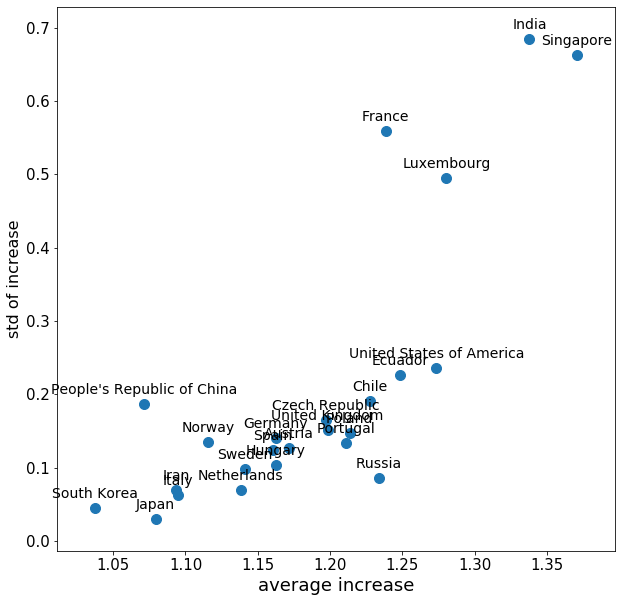

In [20]:
ax = finaldata.plot.scatter(x='average',y='std',s=100,figsize=(10,10), fontsize=15)

xs = finaldata['average'].values
ys = finaldata['std'].values
country = finaldata['country']

plt.xlabel('average increase', fontsize=18)
plt.ylabel('std of increase', fontsize=16)

# zip joins x and y coordinates in pairs
for x,y,label in zip(xs,ys,country):

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',fontsize=14) # horizontal alignment can be left, right or center


plt.show()
